In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import random
import seaborn as sns
from sklearn import datasets
from tqdm import tqdm

%matplotlib inline

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchsummary import summary
from torch.autograd import grad

SEED = 999
torch.manual_seed(SEED)

In [4]:
plt.rcParams.update({'font.size': 20})

In [5]:
path = './input/'
os.listdir(path)

[]

In [6]:
class SyntheticDataGenerator(object):
    """superclass of all synthetic data. WARNING: doesn't raise StopIteration so it loops forever!"""

    def __iter__(self):
        return self

    def __next__(self):
        return self.get_batch()

    def get_batch(self):
        raise NotImplementedError()

    def float_tensor(self, batch):
        return torch.from_numpy(batch).type(torch.FloatTensor)


In [7]:
class StandardGaussianGenerator(SyntheticDataGenerator):
    """samples from Standard Gaussian."""

    def __init__(self,
                 batch_size: int=256,
                 scale: float=1.,
                 eps_noise: float=1.):
        self.batch_size = batch_size
        scale = scale
        self.eps_noise = eps_noise

    def get_batch(self):
        batch = []
        for _ in range(self.batch_size):
            point = np.random.randn(2) * self.eps_noise
            batch.append(point)
        batch = np.array(batch, dtype='float32')
        batch = self.float_tensor(batch)
        batch = batch[torch.randperm(batch.size(0)), :]
        return batch


In [8]:
class Eight_GMM_Generator(SyntheticDataGenerator):
    """samples from four 2D gaussians."""

    def __init__(self,
                 batch_size: int=256,
                 scale: float=10.,
                 eps_noise: float=.5):
        self.batch_size = batch_size
        scale = scale
        self.eps_noise = eps_noise

        centers = [
            (1,0),
            (-1,0),
            (0,1),
            (0,-1),
            (1./np.sqrt(2), 1./np.sqrt(2)),
            (1./np.sqrt(2), -1./np.sqrt(2)),
            (-1./np.sqrt(2), 1./np.sqrt(2)),
            (-1./np.sqrt(2), -1./np.sqrt(2))
        ]
        
        self.centers = [(scale*x,scale*y) for x,y in centers]

    def get_batch(self):
        batch = []
        for i in range(self.batch_size):
            
            point = np.random.randn(2) * self.eps_noise
            center = self.centers[i % 8]
            point[0] += center[0]
            point[1] += center[1]
            batch.append(point)

        batch = np.array(batch, dtype='float32')
        batch = self.float_tensor(batch)
        batch = batch[torch.randperm(batch.size(0)), :]
        return batch

In [9]:
## Gaussian to Gaussian
Id = 2
N = 10000


In [10]:
x_data = Eight_GMM_Generator(N)
x_batch = next(x_data)
x_batch.shape

torch.Size([10000, 2])

In [11]:
y_data = StandardGaussianGenerator(N)
y_batch = next(y_data)
y_batch.shape

torch.Size([10000, 2])

In [12]:
P = x_batch.numpy()
Q = y_batch.numpy()

Q.shape, P.shape

((10000, 2), (10000, 2))

In [13]:
mu_q = Q[:,:2].mean(axis=0)
mu_p = P[:,:2].mean(axis=0)

mu_q, mu_p

(array([0.0125513 , 0.00283652], dtype=float32),
 array([ 0.00314896, -0.00385853], dtype=float32))

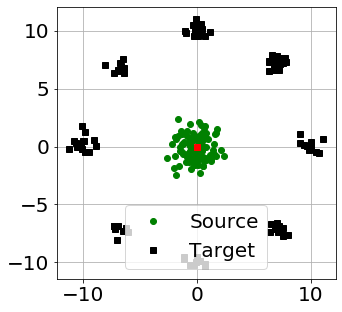

In [14]:
plt.figure(figsize=(5,5))
plt.plot(Q[:100,0],Q[:100,1],'og',label='Source')
plt.plot(P[:100,0],P[:100,1],'sk',label='Target')

plt.plot(mu_q[0],mu_q[1],'or')
plt.plot(mu_p[0],mu_p[1],'sr')

plt.legend()
plt.grid()

In [15]:
Q.shape, P.shape

((10000, 2), (10000, 2))

In [16]:
x = torch.FloatTensor(P[:3]).cuda()
y = torch.FloatTensor(Q[:3]).cuda()
x.shape, y.shape

(torch.Size([3, 2]), torch.Size([3, 2]))

In [17]:
class Ki(nn.Module):
    def __init__(self, features = 128):
        super(Ki, self).__init__()
        
        self.W0b0 = nn.Linear(in_features=Id, out_features=features)
        
        self.W1b1 = nn.Linear(in_features=features, out_features=features)
        
        self.W2b2 = nn.Linear(in_features=features, out_features=features)
        
        self.W3b3 = nn.Linear(in_features=features, out_features=Id)
        
        
    def forward(self, x):
        x = F.leaky_relu(self.W0b0(x))
        x = F.leaky_relu(self.W1b1(x))
        x = F.leaky_relu(self.W2b2(x))
        op = self.W3b3(x)
        
        return op
        

In [18]:
ki = Ki().cuda()
summary(ki,(1,Id))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]             384
            Linear-2               [-1, 1, 128]          16,512
            Linear-3               [-1, 1, 128]          16,512
            Linear-4                 [-1, 1, 2]             258
Total params: 33,666
Trainable params: 33,666
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.13
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


In [19]:
class Psi(nn.Module):
    def __init__(self, features = 128):
        super(Psi, self).__init__()
        
        self.W0b0 = nn.Linear(in_features=Id, out_features=features)
        
        self.W1b1 = nn.Linear(in_features=features, out_features=features)
        
        self.W2b2 = nn.Linear(in_features=features, out_features=features)
        
        self.W3b3 = nn.Linear(in_features=features, out_features=1)
        
        
    def forward(self, x):
        x = F.leaky_relu(self.W0b0(x))
        x = F.leaky_relu(self.W1b1(x))
        x = F.leaky_relu(self.W2b2(x))
        op = self.W3b3(x)
        
        return op
        

In [20]:
psi = Psi().cuda()
summary(psi,(1,Id))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]             384
            Linear-2               [-1, 1, 128]          16,512
            Linear-3               [-1, 1, 128]          16,512
            Linear-4                 [-1, 1, 1]             129
Total params: 33,537
Trainable params: 33,537
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.13
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


In [21]:
torch.rand(1)

tensor([0.1378])

In [22]:
def PushForward(ki,x):
    gradPhi = ki(x)
    return gradPhi

In [23]:
def GradientPenalty(psi, ki, x, y):
    batch_size = x.shape[0]
    ip1 = nn.Parameter(x, requires_grad = True)
    ip2 = torch.mean(ki(ip1))
    
    eta =torch.rand(1).cuda()
    ip = nn.Parameter((eta*y+(1-eta)*ip2), requires_grad=True)
    op = torch.mean(psi(ip))
    
    # compute gradient penalty
    gp = torch.norm(grad(op, ip, create_graph=True)[0]*batch_size, 'fro', dim=1)
    gp = torch.mean((gp-1)**2)
    
    return gp

gp = GradientPenalty(psi, ki, x, y)
gp

tensor(0.8856, device='cuda:0', grad_fn=<MeanBackward0>)

In [24]:
def WassersteinLoss(psi,ki,x,y):
    yp = PushForward(ki,x)
    dot = torch.mean(x*yp, dim=1).unsqueeze(dim=1)
    
    loss = (psi(y) + dot - psi(yp)).mean()
    return loss

loss = WassersteinLoss(psi,ki,x,y)
loss

tensor(-1.1260, device='cuda:0', grad_fn=<MeanBackward0>)

In [25]:
T = 10001
M = 128
K_ki = 16
lam_gp =1.

parallel = True

In [26]:
psi = Psi()
ki = Ki()

if parallel:
    psi = nn.DataParallel(psi, [0,1])
    ki = nn.DataParallel(ki, [0,1])

psi.cuda()
ki.cuda()


DataParallel(
  (module): Ki(
    (W0b0): Linear(in_features=2, out_features=128, bias=True)
    (W1b1): Linear(in_features=128, out_features=128, bias=True)
    (W2b2): Linear(in_features=128, out_features=128, bias=True)
    (W3b3): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [27]:
Ki_opt = optim.Adam(ki.parameters(), betas=(0.5,0.99), lr = 1e-3)
Psi_opt = optim.Adam(psi.parameters(), betas=(0.5,0.99), lr = 1e-3)

In [28]:
%%time
psi_l = []
ki_l = []
Gp_l = []

for t in tqdm(range(T)):
    y_idxs = random.sample(range(0,P.shape[0]), M)
    y_batch = torch.FloatTensor(P[y_idxs]).cuda()
    
    ## Multiple infimum updates to restrict exploding loss
    x_idxs = random.sample(range(0,Q.shape[0]), M)
    x_batch = torch.FloatTensor(Q[x_idxs]).cuda()

    ##########################################################
    ## Outer minimization loop
    ##########################################################       
    ## Fix Ki and update Psi to compute infimum. 
    for param in psi.parameters():
        param.requires_grad = True
    for param in ki.parameters():
        param.requires_grad = False

    gp_loss = GradientPenalty(psi, ki, x_batch, y_batch)
    Psi_loss = WassersteinLoss(psi, ki, x_batch, y_batch) + lam_gp * gp_loss

    Psi_opt.zero_grad()
    Psi_loss.backward(retain_graph=True)
    Psi_opt.step()


    psi_l.append(Psi_loss.item())
    Gp_l.append(gp_loss.item())

    ##########################################################
    ## Inner maximization loop: update once for every C updates
    ##########################################################
    ki_l_ = []
    for _ in range(K_ki):
        idxs = random.sample(range(0,P.shape[0]), M)
        y_batch = torch.FloatTensor(P[idxs]).cuda()
        x_batch = torch.FloatTensor(Q[idxs]).cuda()

        # print('Data: ', x_batch.shape, y_batch.shape)

        # sys.exit()
        ## Fix Psi and update Ki to compute convex conjugate/ supremum 
        for param in psi.parameters():
            param.requires_grad = False
        for param in ki.parameters():
            param.requires_grad = True

        Ki_loss = - WassersteinLoss(psi, ki, x_batch, y_batch) 

        Ki_opt.zero_grad()
        Ki_loss.backward(retain_graph=True)
        Ki_opt.step()

        ki_l_.append(Ki_loss.item())
    ki_l.append(np.asarray(ki_l_).mean())
        
    if t%100==0:
        print("Epoch: ", t,"|",T, "\t psi loss: ", np.round(psi_l[-1],3),"\t Gp loss: ",np.round(Gp_l[-1],2), "\t ki loss: ", np.round(ki_l[-1],2)) 
        
        

  0%|          | 1/10001 [00:05<14:45:31,  5.31s/it]

Epoch:  0 | 10001 	 psi loss:  0.778 	 Gp loss:  0.93 	 ki loss:  0.02


  1%|          | 101/10001 [00:30<41:51,  3.94it/s] 

Epoch:  100 | 10001 	 psi loss:  12.109 	 Gp loss:  3.86 	 ki loss:  -1.91


  2%|▏         | 201/10001 [00:55<41:03,  3.98it/s]

Epoch:  200 | 10001 	 psi loss:  -3.578 	 Gp loss:  1.59 	 ki loss:  -5.63


  3%|▎         | 301/10001 [01:19<41:00,  3.94it/s]

Epoch:  300 | 10001 	 psi loss:  8.226 	 Gp loss:  0.49 	 ki loss:  -7.23


  4%|▍         | 401/10001 [01:44<42:41,  3.75it/s]

Epoch:  400 | 10001 	 psi loss:  10.333 	 Gp loss:  0.27 	 ki loss:  -9.1


  5%|▌         | 501/10001 [02:12<44:15,  3.58it/s]

Epoch:  500 | 10001 	 psi loss:  3.186 	 Gp loss:  0.02 	 ki loss:  -8.13


  6%|▌         | 601/10001 [02:40<37:10,  4.22it/s]

Epoch:  600 | 10001 	 psi loss:  4.783 	 Gp loss:  0.32 	 ki loss:  -5.7


  7%|▋         | 701/10001 [03:04<38:54,  3.98it/s]

Epoch:  700 | 10001 	 psi loss:  4.312 	 Gp loss:  0.6 	 ki loss:  -3.29


  8%|▊         | 801/10001 [03:30<40:32,  3.78it/s]

Epoch:  800 | 10001 	 psi loss:  4.862 	 Gp loss:  1.71 	 ki loss:  -2.17


  9%|▉         | 901/10001 [03:56<43:35,  3.48it/s]

Epoch:  900 | 10001 	 psi loss:  -1.859 	 Gp loss:  0.79 	 ki loss:  -1.12


 10%|█         | 1001/10001 [04:24<43:18,  3.46it/s]

Epoch:  1000 | 10001 	 psi loss:  3.895 	 Gp loss:  1.26 	 ki loss:  -2.19


 11%|█         | 1102/10001 [04:50<28:29,  5.20it/s]

Epoch:  1100 | 10001 	 psi loss:  5.627 	 Gp loss:  0.61 	 ki loss:  -3.74


 12%|█▏        | 1201/10001 [05:18<41:03,  3.57it/s]

Epoch:  1200 | 10001 	 psi loss:  6.117 	 Gp loss:  0.17 	 ki loss:  -4.79


 13%|█▎        | 1301/10001 [05:46<41:04,  3.53it/s]

Epoch:  1300 | 10001 	 psi loss:  5.682 	 Gp loss:  0.44 	 ki loss:  -5.47


 14%|█▍        | 1401/10001 [06:14<39:46,  3.60it/s]

Epoch:  1400 | 10001 	 psi loss:  5.669 	 Gp loss:  0.24 	 ki loss:  -6.04


 15%|█▌        | 1501/10001 [06:42<39:52,  3.55it/s]

Epoch:  1500 | 10001 	 psi loss:  6.646 	 Gp loss:  0.1 	 ki loss:  -6.38


 16%|█▌        | 1602/10001 [07:06<23:36,  5.93it/s]

Epoch:  1600 | 10001 	 psi loss:  6.877 	 Gp loss:  0.05 	 ki loss:  -6.34


 17%|█▋        | 1701/10001 [07:27<39:19,  3.52it/s]

Epoch:  1700 | 10001 	 psi loss:  6.447 	 Gp loss:  0.1 	 ki loss:  -6.34


 18%|█▊        | 1801/10001 [07:55<38:21,  3.56it/s]

Epoch:  1800 | 10001 	 psi loss:  6.369 	 Gp loss:  0.09 	 ki loss:  -6.24


 19%|█▉        | 1901/10001 [08:24<37:20,  3.62it/s]

Epoch:  1900 | 10001 	 psi loss:  5.727 	 Gp loss:  0.1 	 ki loss:  -6.25


 20%|██        | 2002/10001 [08:52<26:17,  5.07it/s]

Epoch:  2000 | 10001 	 psi loss:  6.129 	 Gp loss:  0.1 	 ki loss:  -6.51


 21%|██        | 2101/10001 [09:17<36:54,  3.57it/s]

Epoch:  2100 | 10001 	 psi loss:  6.6 	 Gp loss:  0.07 	 ki loss:  -6.47


 22%|██▏       | 2201/10001 [09:45<36:18,  3.58it/s]

Epoch:  2200 | 10001 	 psi loss:  5.7 	 Gp loss:  0.05 	 ki loss:  -6.46


 23%|██▎       | 2301/10001 [10:14<36:41,  3.50it/s]

Epoch:  2300 | 10001 	 psi loss:  6.812 	 Gp loss:  0.03 	 ki loss:  -6.38


 24%|██▍       | 2401/10001 [10:43<36:52,  3.43it/s]

Epoch:  2400 | 10001 	 psi loss:  6.714 	 Gp loss:  0.06 	 ki loss:  -6.38


 25%|██▌       | 2501/10001 [11:10<37:56,  3.29it/s]

Epoch:  2500 | 10001 	 psi loss:  6.062 	 Gp loss:  0.16 	 ki loss:  -6.38


 26%|██▌       | 2601/10001 [11:39<36:26,  3.38it/s]

Epoch:  2600 | 10001 	 psi loss:  6.183 	 Gp loss:  0.1 	 ki loss:  -6.42


 27%|██▋       | 2701/10001 [12:09<35:24,  3.44it/s]

Epoch:  2700 | 10001 	 psi loss:  6.231 	 Gp loss:  0.03 	 ki loss:  -6.38


 28%|██▊       | 2801/10001 [12:38<34:53,  3.44it/s]

Epoch:  2800 | 10001 	 psi loss:  7.173 	 Gp loss:  0.05 	 ki loss:  -6.29


 29%|██▉       | 2901/10001 [13:07<35:09,  3.37it/s]

Epoch:  2900 | 10001 	 psi loss:  6.737 	 Gp loss:  0.2 	 ki loss:  -6.49


 30%|███       | 3001/10001 [13:37<34:05,  3.42it/s]

Epoch:  3000 | 10001 	 psi loss:  6.186 	 Gp loss:  0.14 	 ki loss:  -6.45


 31%|███       | 3101/10001 [14:04<32:39,  3.52it/s]

Epoch:  3100 | 10001 	 psi loss:  6.357 	 Gp loss:  0.08 	 ki loss:  -6.59


 32%|███▏      | 3201/10001 [14:33<33:56,  3.34it/s]

Epoch:  3200 | 10001 	 psi loss:  6.112 	 Gp loss:  0.04 	 ki loss:  -6.35


 33%|███▎      | 3301/10001 [15:03<33:54,  3.29it/s]

Epoch:  3300 | 10001 	 psi loss:  7.034 	 Gp loss:  0.24 	 ki loss:  -6.39


 34%|███▍      | 3401/10001 [15:33<32:13,  3.41it/s]

Epoch:  3400 | 10001 	 psi loss:  6.07 	 Gp loss:  0.06 	 ki loss:  -6.4


 35%|███▌      | 3501/10001 [16:02<32:28,  3.34it/s]

Epoch:  3500 | 10001 	 psi loss:  6.136 	 Gp loss:  0.06 	 ki loss:  -6.31


 36%|███▌      | 3601/10001 [16:32<31:23,  3.40it/s]

Epoch:  3600 | 10001 	 psi loss:  6.189 	 Gp loss:  0.06 	 ki loss:  -6.47


 37%|███▋      | 3701/10001 [16:59<30:38,  3.43it/s]

Epoch:  3700 | 10001 	 psi loss:  6.631 	 Gp loss:  0.25 	 ki loss:  -6.38


 38%|███▊      | 3802/10001 [17:22<18:24,  5.61it/s]

Epoch:  3800 | 10001 	 psi loss:  6.322 	 Gp loss:  0.06 	 ki loss:  -6.57


 39%|███▉      | 3901/10001 [17:48<29:17,  3.47it/s]

Epoch:  3900 | 10001 	 psi loss:  6.672 	 Gp loss:  0.02 	 ki loss:  -6.26


 40%|████      | 4001/10001 [18:17<29:16,  3.42it/s]

Epoch:  4000 | 10001 	 psi loss:  6.609 	 Gp loss:  0.04 	 ki loss:  -6.52


 41%|████      | 4101/10001 [18:46<27:27,  3.58it/s]

Epoch:  4100 | 10001 	 psi loss:  6.195 	 Gp loss:  0.06 	 ki loss:  -6.37


 42%|████▏     | 4201/10001 [19:13<27:18,  3.54it/s]

Epoch:  4200 | 10001 	 psi loss:  6.555 	 Gp loss:  0.06 	 ki loss:  -6.55


 43%|████▎     | 4301/10001 [19:42<27:23,  3.47it/s]

Epoch:  4300 | 10001 	 psi loss:  6.949 	 Gp loss:  0.07 	 ki loss:  -6.36


 44%|████▍     | 4401/10001 [20:12<27:30,  3.39it/s]

Epoch:  4400 | 10001 	 psi loss:  6.249 	 Gp loss:  0.07 	 ki loss:  -6.46


 45%|████▌     | 4501/10001 [20:41<26:56,  3.40it/s]

Epoch:  4500 | 10001 	 psi loss:  6.408 	 Gp loss:  0.02 	 ki loss:  -6.4


 46%|████▌     | 4601/10001 [21:10<26:38,  3.38it/s]

Epoch:  4600 | 10001 	 psi loss:  6.342 	 Gp loss:  0.05 	 ki loss:  -6.34


 47%|████▋     | 4701/10001 [21:39<26:03,  3.39it/s]

Epoch:  4700 | 10001 	 psi loss:  6.704 	 Gp loss:  0.33 	 ki loss:  -6.43


 48%|████▊     | 4801/10001 [22:08<24:58,  3.47it/s]

Epoch:  4800 | 10001 	 psi loss:  6.573 	 Gp loss:  0.03 	 ki loss:  -6.47


 49%|████▉     | 4901/10001 [22:37<25:23,  3.35it/s]

Epoch:  4900 | 10001 	 psi loss:  6.09 	 Gp loss:  0.05 	 ki loss:  -6.42


 50%|█████     | 5001/10001 [23:04<24:09,  3.45it/s]

Epoch:  5000 | 10001 	 psi loss:  6.093 	 Gp loss:  0.02 	 ki loss:  -6.42


 51%|█████     | 5101/10001 [23:33<24:02,  3.40it/s]

Epoch:  5100 | 10001 	 psi loss:  6.663 	 Gp loss:  0.04 	 ki loss:  -6.51


 52%|█████▏    | 5201/10001 [24:01<23:20,  3.43it/s]

Epoch:  5200 | 10001 	 psi loss:  6.613 	 Gp loss:  0.06 	 ki loss:  -6.39


 53%|█████▎    | 5301/10001 [24:30<23:13,  3.37it/s]

Epoch:  5300 | 10001 	 psi loss:  6.461 	 Gp loss:  0.28 	 ki loss:  -6.42


 54%|█████▍    | 5401/10001 [24:59<22:11,  3.45it/s]

Epoch:  5400 | 10001 	 psi loss:  6.645 	 Gp loss:  0.05 	 ki loss:  -6.51


 55%|█████▌    | 5501/10001 [25:28<21:36,  3.47it/s]

Epoch:  5500 | 10001 	 psi loss:  6.964 	 Gp loss:  0.28 	 ki loss:  -6.41


 56%|█████▌    | 5601/10001 [25:57<21:56,  3.34it/s]

Epoch:  5600 | 10001 	 psi loss:  6.898 	 Gp loss:  0.01 	 ki loss:  -6.41


 57%|█████▋    | 5701/10001 [26:27<19:26,  3.69it/s]

Epoch:  5700 | 10001 	 psi loss:  6.461 	 Gp loss:  0.02 	 ki loss:  -6.34


 58%|█████▊    | 5801/10001 [26:56<20:40,  3.39it/s]

Epoch:  5800 | 10001 	 psi loss:  6.354 	 Gp loss:  0.06 	 ki loss:  -6.45


 59%|█████▉    | 5902/10001 [27:23<12:14,  5.58it/s]

Epoch:  5900 | 10001 	 psi loss:  6.583 	 Gp loss:  0.05 	 ki loss:  -6.44


 60%|██████    | 6001/10001 [27:43<19:42,  3.38it/s]

Epoch:  6000 | 10001 	 psi loss:  5.875 	 Gp loss:  0.02 	 ki loss:  -6.21


 61%|██████    | 6101/10001 [28:12<18:34,  3.50it/s]

Epoch:  6100 | 10001 	 psi loss:  6.351 	 Gp loss:  0.13 	 ki loss:  -6.37


 62%|██████▏   | 6201/10001 [28:41<18:07,  3.49it/s]

Epoch:  6200 | 10001 	 psi loss:  6.361 	 Gp loss:  0.01 	 ki loss:  -6.37


 63%|██████▎   | 6301/10001 [29:08<17:54,  3.44it/s]

Epoch:  6300 | 10001 	 psi loss:  6.647 	 Gp loss:  0.02 	 ki loss:  -6.37


 64%|██████▍   | 6401/10001 [29:35<18:18,  3.28it/s]

Epoch:  6400 | 10001 	 psi loss:  6.095 	 Gp loss:  0.06 	 ki loss:  -6.43


 65%|██████▌   | 6501/10001 [30:04<16:53,  3.45it/s]

Epoch:  6500 | 10001 	 psi loss:  6.234 	 Gp loss:  0.05 	 ki loss:  -6.33


 66%|██████▌   | 6601/10001 [30:34<17:10,  3.30it/s]

Epoch:  6600 | 10001 	 psi loss:  6.579 	 Gp loss:  0.01 	 ki loss:  -6.51


 67%|██████▋   | 6701/10001 [31:03<16:24,  3.35it/s]

Epoch:  6700 | 10001 	 psi loss:  6.577 	 Gp loss:  0.16 	 ki loss:  -6.43


 68%|██████▊   | 6801/10001 [31:32<15:31,  3.44it/s]

Epoch:  6800 | 10001 	 psi loss:  5.672 	 Gp loss:  0.03 	 ki loss:  -6.38


 69%|██████▉   | 6901/10001 [32:02<15:10,  3.40it/s]

Epoch:  6900 | 10001 	 psi loss:  7.14 	 Gp loss:  0.05 	 ki loss:  -6.45


 70%|███████   | 7001/10001 [32:30<14:32,  3.44it/s]

Epoch:  7000 | 10001 	 psi loss:  6.068 	 Gp loss:  0.02 	 ki loss:  -6.46


 71%|███████   | 7101/10001 [32:58<12:58,  3.72it/s]

Epoch:  7100 | 10001 	 psi loss:  6.836 	 Gp loss:  0.3 	 ki loss:  -6.37


 72%|███████▏  | 7201/10001 [33:27<13:10,  3.54it/s]

Epoch:  7200 | 10001 	 psi loss:  6.19 	 Gp loss:  0.02 	 ki loss:  -6.35


 73%|███████▎  | 7301/10001 [33:56<12:09,  3.70it/s]

Epoch:  7300 | 10001 	 psi loss:  7.03 	 Gp loss:  0.2 	 ki loss:  -6.37


 74%|███████▍  | 7401/10001 [34:22<12:31,  3.46it/s]

Epoch:  7400 | 10001 	 psi loss:  6.481 	 Gp loss:  0.01 	 ki loss:  -6.37


 75%|███████▌  | 7501/10001 [34:51<11:45,  3.54it/s]

Epoch:  7500 | 10001 	 psi loss:  6.63 	 Gp loss:  0.28 	 ki loss:  -6.39


 76%|███████▌  | 7601/10001 [35:18<11:40,  3.43it/s]

Epoch:  7600 | 10001 	 psi loss:  6.85 	 Gp loss:  0.01 	 ki loss:  -6.63


 77%|███████▋  | 7701/10001 [35:47<10:46,  3.56it/s]

Epoch:  7700 | 10001 	 psi loss:  6.923 	 Gp loss:  0.01 	 ki loss:  -6.4


 78%|███████▊  | 7801/10001 [36:16<10:51,  3.38it/s]

Epoch:  7800 | 10001 	 psi loss:  6.739 	 Gp loss:  0.34 	 ki loss:  -6.43


 79%|███████▉  | 7901/10001 [36:46<10:11,  3.44it/s]

Epoch:  7900 | 10001 	 psi loss:  6.654 	 Gp loss:  0.02 	 ki loss:  -6.35


 80%|████████  | 8001/10001 [37:15<09:35,  3.48it/s]

Epoch:  8000 | 10001 	 psi loss:  6.577 	 Gp loss:  0.1 	 ki loss:  -6.47


 81%|████████  | 8102/10001 [37:39<05:35,  5.67it/s]

Epoch:  8100 | 10001 	 psi loss:  6.799 	 Gp loss:  0.04 	 ki loss:  -6.47


 82%|████████▏ | 8201/10001 [38:02<08:58,  3.34it/s]

Epoch:  8200 | 10001 	 psi loss:  6.185 	 Gp loss:  0.0 	 ki loss:  -6.36


 83%|████████▎ | 8301/10001 [38:31<08:14,  3.44it/s]

Epoch:  8300 | 10001 	 psi loss:  6.321 	 Gp loss:  0.06 	 ki loss:  -6.37


 84%|████████▍ | 8401/10001 [39:00<07:56,  3.36it/s]

Epoch:  8400 | 10001 	 psi loss:  6.041 	 Gp loss:  0.03 	 ki loss:  -6.4


 85%|████████▌ | 8501/10001 [39:27<07:08,  3.50it/s]

Epoch:  8500 | 10001 	 psi loss:  6.302 	 Gp loss:  0.01 	 ki loss:  -6.53


 86%|████████▌ | 8601/10001 [39:56<06:56,  3.36it/s]

Epoch:  8600 | 10001 	 psi loss:  5.956 	 Gp loss:  0.03 	 ki loss:  -6.39


 87%|████████▋ | 8701/10001 [40:26<06:32,  3.31it/s]

Epoch:  8700 | 10001 	 psi loss:  6.803 	 Gp loss:  0.01 	 ki loss:  -6.39


 88%|████████▊ | 8801/10001 [40:55<05:33,  3.60it/s]

Epoch:  8800 | 10001 	 psi loss:  6.596 	 Gp loss:  0.02 	 ki loss:  -6.44


 89%|████████▉ | 8901/10001 [41:22<05:03,  3.62it/s]

Epoch:  8900 | 10001 	 psi loss:  6.5 	 Gp loss:  0.26 	 ki loss:  -6.38


 90%|█████████ | 9001/10001 [41:51<04:47,  3.48it/s]

Epoch:  9000 | 10001 	 psi loss:  6.496 	 Gp loss:  0.02 	 ki loss:  -6.39


 91%|█████████ | 9101/10001 [42:20<04:33,  3.29it/s]

Epoch:  9100 | 10001 	 psi loss:  6.465 	 Gp loss:  0.26 	 ki loss:  -6.55


 92%|█████████▏| 9201/10001 [42:50<03:58,  3.36it/s]

Epoch:  9200 | 10001 	 psi loss:  6.336 	 Gp loss:  0.02 	 ki loss:  -6.45


 93%|█████████▎| 9301/10001 [43:19<03:24,  3.42it/s]

Epoch:  9300 | 10001 	 psi loss:  6.858 	 Gp loss:  0.01 	 ki loss:  -6.51


 94%|█████████▍| 9401/10001 [43:48<02:55,  3.43it/s]

Epoch:  9400 | 10001 	 psi loss:  6.358 	 Gp loss:  0.01 	 ki loss:  -6.35


 95%|█████████▌| 9501/10001 [44:15<02:22,  3.51it/s]

Epoch:  9500 | 10001 	 psi loss:  6.438 	 Gp loss:  0.05 	 ki loss:  -6.48


 96%|█████████▌| 9601/10001 [44:44<01:59,  3.33it/s]

Epoch:  9600 | 10001 	 psi loss:  6.499 	 Gp loss:  0.01 	 ki loss:  -6.45


 97%|█████████▋| 9701/10001 [45:13<01:27,  3.44it/s]

Epoch:  9700 | 10001 	 psi loss:  6.304 	 Gp loss:  0.0 	 ki loss:  -6.38


 98%|█████████▊| 9801/10001 [45:43<00:57,  3.50it/s]

Epoch:  9800 | 10001 	 psi loss:  6.43 	 Gp loss:  0.01 	 ki loss:  -6.31


 99%|█████████▉| 9901/10001 [46:12<00:30,  3.31it/s]

Epoch:  9900 | 10001 	 psi loss:  6.396 	 Gp loss:  0.01 	 ki loss:  -6.28


100%|██████████| 10001/10001 [46:41<00:00,  3.43it/s]

Epoch:  10000 | 10001 	 psi loss:  6.584 	 Gp loss:  0.01 	 ki loss:  -6.23
CPU times: user 45min 19s, sys: 9min 33s, total: 54min 53s
Wall time: 46min 41s


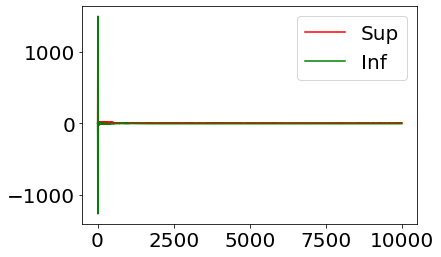

In [29]:
plt.plot(psi_l,'r', label='Sup')
plt.plot(ki_l,'g', label='Inf')
plt.legend()

In [30]:
plt.rcParams.update({'font.size': 30})

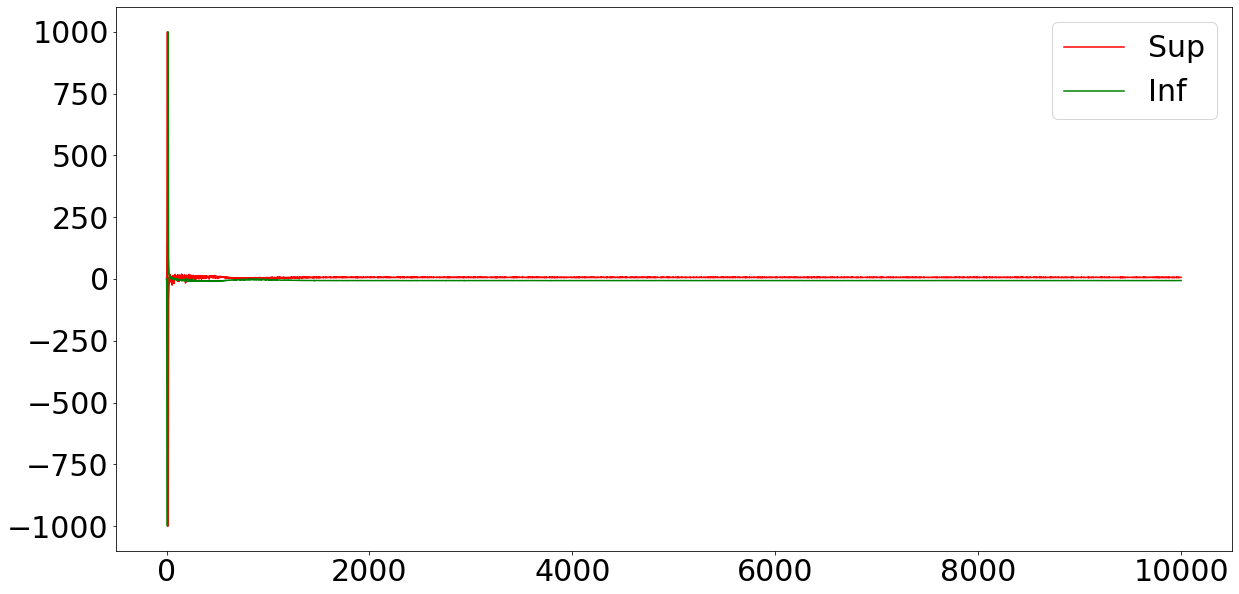

In [31]:
psi_l = np.asarray(psi_l)
ki_l = np.asarray(ki_l)

psi_l[psi_l>1e+3] = 1e+3
ki_l[ki_l>1e+3] = 1e+3

psi_l[psi_l<-1e+3] = -1e+3
ki_l[ki_l<-1e+3] = -1e+3

plt.figure(figsize=(20,10))
plt.plot(psi_l,'r', label='Sup')
plt.plot(ki_l,'g', label='Inf')
plt.legend()

plt.savefig('./output/Toy/OTM_Barry8Gauss_training.jpg', bbox_inches='tight')


In [32]:
## Compute Transport plan
n = 200
indxs = random.sample(range(0,P.shape[0]), n)

y = torch.FloatTensor(P[indxs]).cuda()
x = torch.FloatTensor(Q[indxs]).cuda()
Tx = PushForward(ki,x)

x.shape, y.shape, Tx.shape

(torch.Size([200, 2]), torch.Size([200, 2]), torch.Size([200, 2]))

In [33]:
x = x.detach().cpu().numpy()
y = y.detach().cpu().numpy()
Tx = Tx.detach().cpu().numpy()
mu_t = Tx.mean(axis=0)

x.shape, y.shape, Tx.shape

((200, 2), (200, 2), (200, 2))

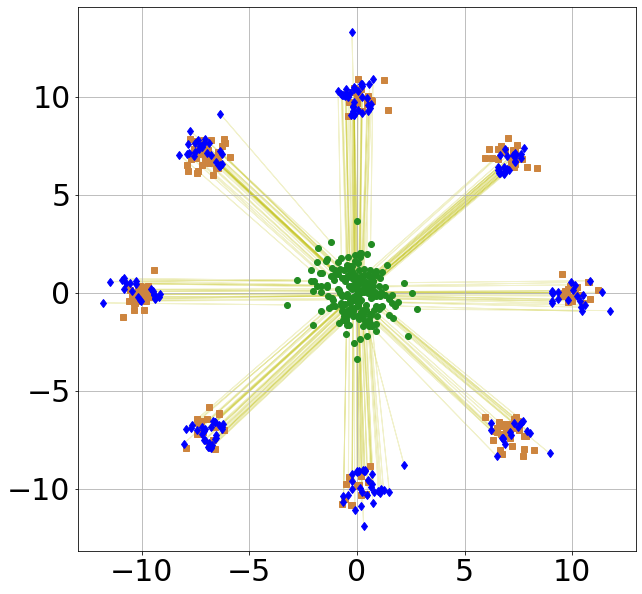

In [62]:
plt.figure(figsize=(10,10))
plt.plot(x[:,0],x[:,1],'og',label='Input (x)', color='forestgreen')
plt.plot(y[:,0],y[:,1],'s',label='Output (y)', color='peru')
plt.plot(Tx[:,0],Tx[:,1],'d',label='Transport (Tx)', color='blue')

for i in range(x.shape[0]):
    plt.arrow(x[i,0], x[i,1], Tx[i,0] - x[i,0], Tx[i,1] - x[i,1],  alpha=0.2, head_width=0.03, head_length = 0.05, fc='y', ec = 'y', color='y')

# plt.legend()
plt.grid()

plt.savefig('./output/Toy/OTM_Barry8Gauss_grid.pdf', bbox_inches='tight')


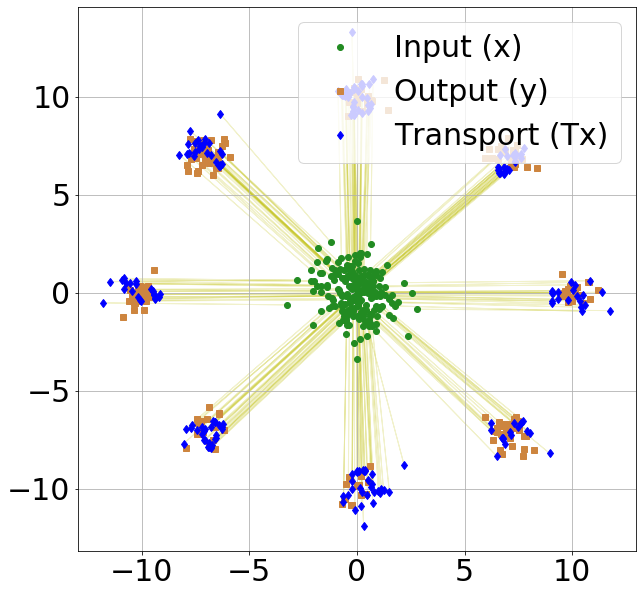

In [61]:
plt.figure(figsize=(10,10))
plt.plot(x[:,0],x[:,1],'og',label='Input (x)', color='forestgreen')
plt.plot(y[:,0],y[:,1],'s',label='Output (y)', color='peru')
plt.plot(Tx[:,0],Tx[:,1],'d',label='Transport (Tx)', color='blue')

for i in range(x.shape[0]):
    plt.arrow(x[i,0], x[i,1], Tx[i,0] - x[i,0], Tx[i,1] - x[i,1],  alpha=0.2, head_width=0.03, head_length = 0.05, fc='y', ec = 'y', color='y')

plt.legend()
plt.grid('off')

plt.savefig('./output/Toy/OTM_Barry8Gauss.jpg', bbox_inches='tight')
